# Fifth Exercise (Chapter 10)

This exercise focuses on recurrent neural networks (RNN). Also, we'll be using Pytorch from now on 🎉!

We will:
- implement an LSTM cell in Pytorch,
- train two forms of RNNs, namely:
    - many to one: value memorization
    - many to many: de-noising sequences

In [1]:
from typing import Tuple, Union

import numpy as np  # generate training data
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## Preliminary Questions

Before we dive into the implementation parts, let's think about a few aspects of recurrent neural networks.
*Hint: Reading chapter 10 of the deep learning book might help with answering the questions.* Two other great resources are:
- Andrej Karpathy's [blog post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), which, among other things, nicely explains the different variants of RNNs (one-to-one, many-to-many, etc).
- Chris Olah's [blog post on LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).



**1.** In what sense are convolutional neural networks and recurrent neural networks similar? In what sense are they different?

**Answer**:  
**Similar:** Both neural networks make use of "parameter sharing", meaning that a rather small set of parameters (compared to a fully connected NN of different size) is used to detect features at different locations within the input data. For CNNs this location may vary in space (e.g. when detecting the same feature at different locations within an image), for RNNs the location may vary in time (e.g. when extracting similar information from sentences with different length).
**Different:** While the topology of a CNN is a directed acyclic graph, in a RNN will occure loops from cells to themselves or cycles involving more cells. Also an RNN model will process arbitrary input dimensions while a CNN needs fixed input dimensions.

**2.** How can one counteract vanishing or exploding gradients in RNNs, allowing to learn long-term dependencies?

**Answer**:  
**Exploding gradients:** Use clipping, i.e. limit the gradient during each backpropagation step.
**Vanishing gradients:** Using regularization or use ReLU instead of tanh or sigmoid since ReLU derivative is a constant 0 or 1 thus won't provoke vanishing gradients as much.
Or use LSTM cells where the cell state is specifically designed to avoid the vanishing gradient problem by acting as a "gradient pipeline".

## LSTM cell
See chapter 10.10.1 of the DL book.

In Pytorch, all layers inherit from `nn.Module` and implement the `forward` function (the `backward` pass is computed automatically). Parameters should be initialized in the constructor.

To get a feeling for how layers are implemented in pytorch, you can for example take a look at the source code of the [Linear layer](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear) ($h = wX+b$).

Your task here is to implement the LSTMCell, which takes a feature tensor and the hidden state as input and returns the new hidden state (sometimes also referred to as output) and the new cell state.


In [2]:
class LSTMCell(nn.Module):
    """The LSTM layer."""

    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # START TODO #############
        self.Ui = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.Uc = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.Uf = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.Uo = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.Wi = nn.Parameter(torch.rand(hidden_size, input_size))
        self.Wc = nn.Parameter(torch.rand(hidden_size, input_size))
        self.Wf = nn.Parameter(torch.rand(hidden_size, input_size))
        self.Wo = nn.Parameter(torch.rand(hidden_size, input_size))
        self.bi = nn.Parameter(torch.rand(hidden_size))
        self.bc = nn.Parameter(torch.rand(hidden_size))
        self.bf = nn.Parameter(torch.rand(hidden_size))
        self.bo = nn.Parameter(torch.rand(hidden_size))
        # END TODO #############

    def forward(self, x: torch.Tensor, hx: Tuple[torch.Tensor] = None) -> Tuple[torch.Tensor]:
        """
        Args:
            x: The input tensor with shape (batch_size, feature_dim)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size).

        Returns:
            Tuple as (output_hidden, new_internal_state).
        """

        batch_size = x.shape[0]

        if hx is None:
            hx = self._init_hidden_state(x)
        h, C = hx
        hOut, COut = self._init_hidden_state(x)

        # START TODO #############
        tanh = nn.Tanh()

        for i in range(batch_size):
            ft = torch.sigmoid(torch.matmul(self.Wf,x[i]) +
                               torch.matmul(self.Uf,h[i]) +
                               self.bf)

            it = torch.sigmoid(torch.matmul(self.Wi,x[i]) +
                               torch.matmul(self.Ui,h[i]) +
                               self.bi)

            ot = torch.sigmoid(torch.matmul(self.Wo,x[i]) +
                               torch.matmul(self.Uo,h[i]) +
                               self.bo)

            gt = tanh(torch.matmul(self.Wc,x[i]) +
                      torch.matmul(self.Uc,h[i]) +
                      self.bc)

            COut[i] = ft * C[i] + it*gt
            hOut[i] = ot*tanh(COut[i])

        return hOut, COut

    def _init_hidden_state(self, x):
        """Returns the hidden state with zeros.

        Returns:
            A two-tuple (initial_hidden_state, initial_cell_state).
            Both are all zeros with shape (batch_size, hidden_size).
        """
        # START TODO #############
        return torch.zeros(x.shape[0], self.hidden_size), torch.zeros(x.shape[0], self.hidden_size)
        # END TODO #############

In [3]:
class LSTM(LSTMCell):
    """Convenience class that automatically iterates over the sequence."""

    def forward(self, x: Union[np.ndarray, torch.Tensor], hx=None):
        """Iterate over the sequence and apply the LSTM cell.

        Args:
            x: The input tensor with shape (seq_len, batch, input_size)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size). If None, set to zero.

        Returns:
            Tuple as (output_stacked_hidden, new_internal_state).
            output_stacked_hidden is the stacked output of all LSTMCells
            (excluding the cell state!)
        """
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x, requires_grad=True)

        hs = []
        C = None

        # START TODO #############
        for seq_elem in x:
            hx = super().forward(seq_elem, hx)
            h,C = hx

            hs.append(h)
        # END TODO #############

        hOut = torch.stack(hs)

        return hOut, hx

As a simple test, let's see if the LSTM can learn to echo a value at a specific index of the sequence. If your implementation is correct, you should get around 97% accuracy.

In [4]:
# Create 100 training sequences of length 10
num_samples = 1000
seq_length = 10
batch_size = 5
# we use a hidden size larger 1 as it makes training easier
# as prediction we compute the mean over the output.
hidden_size = 6
training_sequences = torch.rand(seq_length, num_samples, 1)
test_sequences = torch.rand(seq_length, 100, 1)
model = LSTM(1, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')

def accuracy(y, label, eps=1e-2):
    assert y.shape == label.shape, (y.shape, label.shape)
    return np.sum(np.abs(y - label) < eps) / len(y)

for epoch in range(101):
    print('epoch ' + str(epoch))
    for batch_idx in range(num_samples // batch_size):
        optimizer.zero_grad()
        batch = training_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
        output = model(batch)[1][0]
        labels = batch[1]  # echo the second element
        loss = loss_fn(labels, output)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"epoch: {epoch}, loss:{loss}")
        output = model(test_sequences)[1][0]
        labels = test_sequences[1]  # echo the second element
        acc = accuracy(np.squeeze(labels.numpy()),
                       np.mean(output.detach().numpy(), axis=-1))
        print(f"test accuracy: {acc}")
    scheduler.step()

epoch 0
epoch: 0, loss:1.3772958517074585
test accuracy: 0.02
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch: 10, loss:0.13923722505569458
test accuracy: 0.12
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch: 20, loss:0.01019394863396883
test accuracy: 0.35
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch: 30, loss:0.021726001054048538
test accuracy: 0.19
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch: 40, loss:0.042778048664331436
test accuracy: 0.11
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch: 50, loss:0.002723710611462593
test accuracy: 0.78
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch: 60, loss:0.0026195982936769724
test accuracy: 0.81
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epo

## LSTM Use Case - Noise Removal
Implement an RNN to remove noise from different sine function instances. If you didn't finish the `LSTM` implementation part, you can use `nn.LSTM` here.

The goal is to remove gaussian noise from a sequence generated from a sine function.

To get an idea what the data look like, plot six different sine function instances with and without noise.

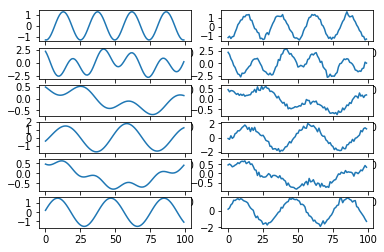

In [7]:
# let's create a generator for sine functions with different amplitudes, shift and frequency
%matplotlib inline

class RandomSineFunction:

    def __init__(self):
        num_sines = np.random.randint(1, 4)
        self.amplitude = np.random.uniform(0, 2, num_sines)
        self.offsets = np.random.uniform(-np.pi, np.pi, num_sines)
        self.frequency = np.random.uniform(0.1, 1, num_sines)

    def __call__(self, x):
        return np.array([a * np.sin(np.pi * f * x + o)
                         for a, f, o in zip(self.amplitude, self.frequency, self.offsets)]).sum(axis=0)


def sample_sine_functions(num_functions):
    return [RandomSineFunction() for _ in range(num_functions)]


def noisy(y, noise_ratio=0.05, axes=None):
    noise_range = np.ptp(y, axis=axes, keepdims=True) * noise_ratio
    return y + np.random.normal(0, noise_range, size=y.shape)

# START TODO #############
nbPlots = 6

fs = sample_sine_functions(nbPlots)
fig, axes = plt.subplots(nbPlots,2)
x = np.linspace(0,10,100)

for i in range(nbPlots):
    axes[i,0].plot(fs[i](x))
    axes[i,1].plot(noisy(fs[i](x)))
plt.show()
# END TODO #############

Now it's time to define the model! Let's stack two LSTMs both with output shape (sequence_length, batch_size, hidden_size) followed by a Linear layer which takes a (sequence_length, batch_size, hidden_size) vector as input and outputs a tensor with shape (sequence_length, batch_size, 1).


To allow the model to see some values before estimating the output, pad the sequence accordingly.

In [8]:
class NoiseRemovalModel(nn.Module):
    """
    """

    def __init__(self, hidden_size: int, shift: int = 10):
        """
        Args:
            hidden_size: the number of units of the LSTM hidden state size.
            shift:       the number of steps the RNN is run before its output
                             is considered ("many-to-many shifted to the right").
        """
        super().__init__()
        self.shift = shift

        # START TODO #############
        # we cannot use nn.Sequential because of the weird operation in the forward pass
        self.s1 = nn.LSTM(input_size = 1, hidden_size = hidden_size)
        self.s2 = nn.LSTM(input_size = hidden_size, hidden_size = hidden_size)
        self.s3 = nn.Linear(in_features = hidden_size, out_features = 1)
        # END TODO #############

    def forward(self, x: np.ndarray) -> torch.Tensor:
        """Forward pass of noise removal.

        This function
        1) pads the input sequence with self.interval zeros at the end,
        2) applies an LSTM
        3) cuts the first self.interval outputs
        4) applies another LSTM
        5) applies Linear layer.

        Args:
            x: The input sequence

        Returns:
            A torch.Tensor of shape (sequence length, batch_size, 1)
        """
        # Pad input sequence x at the end (shifted many-to-many model).
        # This allows the model to see a few numbers before it has to guess
        # the noiseless output.

        # START TODO #############
        x_padded = torch.cat((x,torch.zeros(self.shift,x.shape[1],x.shape[2])), 0)
        out1,_ = self.s1.forward(x_padded)
        out1_cut = out1[10:,...]
        out2,_ = self.s2.forward(out1_cut)
        out3 = self.s3.forward(out2)
        return out3
        # END TODO #############

In [9]:
num_functions = 200
sequence_length = 80
noise_ratio = 0.05
np.random.seed(0)
train_functions = sample_sine_functions(num_functions)
val_functions = sample_sine_functions(50)
# interval on which we'll train and evaluate
x = np.linspace(0, 5, sequence_length)


def prepare_sequences(functions):
    """Convert to tensor and create noisy sequence"""
    sequences = np.array([f(x).reshape(-1, 1) for f in functions])
    # put the sequence into the first dimension
    sequences = sequences.transpose([1, 0, 2])
    # add some noise
    noisy_sequences = noisy(sequences, noise_ratio, axes=(0, 2))
    return torch.Tensor(sequences), torch.Tensor(noisy_sequences)

train_sequences, noisy_train_sequences = prepare_sequences(train_functions)
val_sequences, noisy_val_sequences = prepare_sequences(val_functions)


In [10]:
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def plot_curves(ground_truth, noisy_sequence, model_output):
    plt.figure(figsize=(14, 3))
    for i in range(min(len(ground_truth), 5)):
        plt.subplot(1, 5, i + 1)
        plt.plot(x, ground_truth[i], label="ground_truth")
        plt.plot(x, noisy_sequence[i], label="noisy_sequence")
        plt.plot(x, model_output[i], label="model_output")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.show()


def percentage_noise_removed(ground_truth, noisy_sequence, model_output):
    """Computes the percentage of noise the model removed."""
    return 100 * (1 - (np.abs(ground_truth - model_output).sum() /
                       np.abs(ground_truth - noisy_sequence).sum()))


def train(model, optimizer, scheduler, num_epochs, batch_size, plot=True):
    for epoch in range(num_epochs):
        # START TODO #############
        # training loop here
        optimizer.zero_grad()
        output = model(noisy_train_sequences)
        loss = loss_fn(train_sequences, output)
        loss.backward()
        optimizer.step()
        # END TODO #############
        print(f"epoch: {epoch}, train loss:{loss}")
        # compute the validation loss
        output = model(noisy_val_sequences)
        loss = loss_fn(val_sequences, output)
        print(f"epoch: {epoch}, validation loss:{loss}")
        if epoch % 10 == 0:
            np_tensors = [a.detach().numpy().transpose([1, 0, 2])
                          for a in (val_sequences, noisy_val_sequences, output)]
            if plot:
                plot_curves(*np_tensors)
            print(f"{percentage_noise_removed(*np_tensors):2.4f}% of noise removed.")
        scheduler.step()

epoch: 0, train loss:23387.125
epoch: 0, validation loss:4939.89990234375


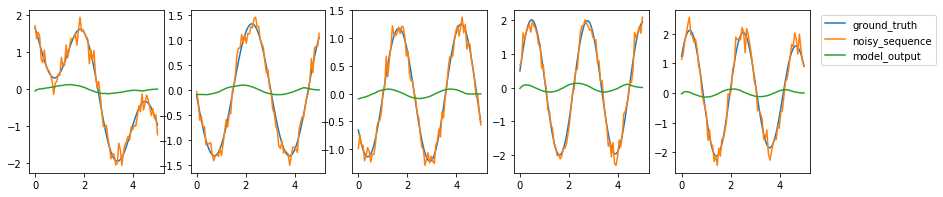

-605.9975% of noise removed.
epoch: 1, train loss:21496.919921875
epoch: 1, validation loss:4185.54638671875
epoch: 2, train loss:17922.580078125
epoch: 2, validation loss:2664.6015625
epoch: 3, train loss:11314.234375
epoch: 3, validation loss:1654.3623046875
epoch: 4, train loss:7288.77197265625
epoch: 4, validation loss:2765.670654296875
epoch: 5, train loss:10491.8095703125
epoch: 5, validation loss:2236.128662109375
epoch: 6, train loss:8505.712890625
epoch: 6, validation loss:1754.45556640625
epoch: 7, train loss:7472.59619140625
epoch: 7, validation loss:1625.185791015625
epoch: 8, train loss:7015.3603515625
epoch: 8, validation loss:1569.509765625
epoch: 9, train loss:6782.7275390625
epoch: 9, validation loss:1630.266357421875
epoch: 10, train loss:7065.5546875
epoch: 10, validation loss:1648.4310302734375


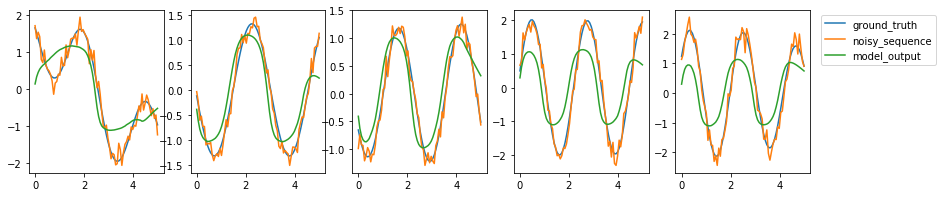

-286.7875% of noise removed.
epoch: 11, train loss:7201.79345703125
epoch: 11, validation loss:1552.08544921875
epoch: 12, train loss:6867.94970703125
epoch: 12, validation loss:1388.2493896484375
epoch: 13, train loss:6240.22216796875
epoch: 13, validation loss:1274.207275390625
epoch: 14, train loss:5772.3291015625
epoch: 14, validation loss:1313.3751220703125
epoch: 15, train loss:5827.2021484375
epoch: 15, validation loss:1377.3310546875
epoch: 16, train loss:5950.60107421875
epoch: 16, validation loss:1211.596923828125
epoch: 17, train loss:5297.30224609375
epoch: 17, validation loss:1023.9243774414062
epoch: 18, train loss:4558.1357421875
epoch: 18, validation loss:965.1032104492188
epoch: 19, train loss:4284.28466796875
epoch: 19, validation loss:965.2008056640625
epoch: 20, train loss:4233.96142578125
epoch: 20, validation loss:937.71435546875


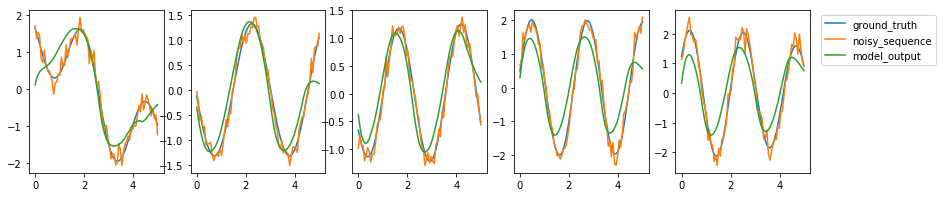

-186.8762% of noise removed.
epoch: 21, train loss:4100.85498046875
epoch: 21, validation loss:870.2825317382812
epoch: 22, train loss:3833.26611328125
epoch: 22, validation loss:791.3666381835938
epoch: 23, train loss:3440.4306640625
epoch: 23, validation loss:784.1624145507812
epoch: 24, train loss:3256.028564453125
epoch: 24, validation loss:786.086669921875
epoch: 25, train loss:3223.122802734375
epoch: 25, validation loss:703.2001953125
epoch: 26, train loss:3009.0791015625
epoch: 26, validation loss:654.90283203125
epoch: 27, train loss:2825.440673828125
epoch: 27, validation loss:694.3974609375
epoch: 28, train loss:2945.155517578125
epoch: 28, validation loss:689.2699584960938
epoch: 29, train loss:2921.17041015625
epoch: 29, validation loss:612.52294921875
epoch: 30, train loss:2617.2080078125
epoch: 30, validation loss:573.1388549804688


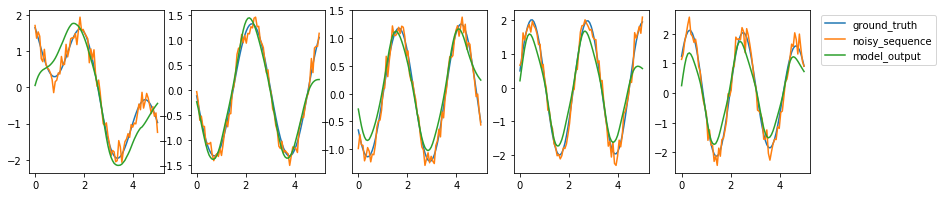

-115.4704% of noise removed.
epoch: 31, train loss:2462.46875
epoch: 31, validation loss:577.348876953125
epoch: 32, train loss:2447.309326171875
epoch: 32, validation loss:561.803955078125
epoch: 33, train loss:2346.45654296875
epoch: 33, validation loss:527.0437622070312
epoch: 34, train loss:2217.074462890625
epoch: 34, validation loss:492.3087463378906
epoch: 35, train loss:2121.797119140625
epoch: 35, validation loss:463.3236999511719
epoch: 36, train loss:2031.610107421875
epoch: 36, validation loss:435.80145263671875
epoch: 37, train loss:1905.690185546875
epoch: 37, validation loss:412.39923095703125
epoch: 38, train loss:1800.4857177734375
epoch: 38, validation loss:395.7204284667969
epoch: 39, train loss:1721.25439453125
epoch: 39, validation loss:384.1762390136719
epoch: 40, train loss:1654.9522705078125
epoch: 40, validation loss:362.8509521484375


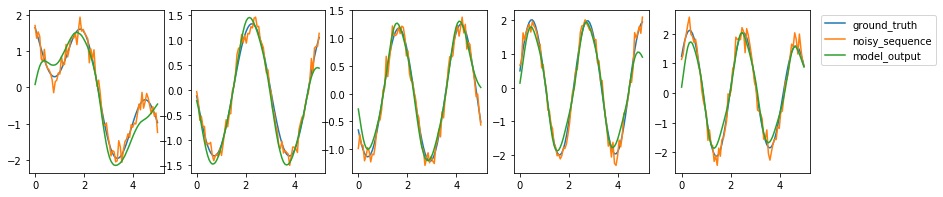

-60.3258% of noise removed.
epoch: 41, train loss:1553.543701171875
epoch: 41, validation loss:338.9705810546875
epoch: 42, train loss:1458.9652099609375
epoch: 42, validation loss:319.4002990722656
epoch: 43, train loss:1399.9691162109375
epoch: 43, validation loss:302.86431884765625
epoch: 44, train loss:1351.7158203125
epoch: 44, validation loss:283.30377197265625
epoch: 45, train loss:1276.444580078125
epoch: 45, validation loss:261.72021484375
epoch: 46, train loss:1185.7462158203125
epoch: 46, validation loss:244.11598205566406
epoch: 47, train loss:1107.696533203125
epoch: 47, validation loss:232.72654724121094
epoch: 48, train loss:1053.4588623046875
epoch: 48, validation loss:219.49688720703125
epoch: 49, train loss:997.5863647460938
epoch: 49, validation loss:203.1698455810547
epoch: 50, train loss:940.3633422851562
epoch: 50, validation loss:191.19688415527344


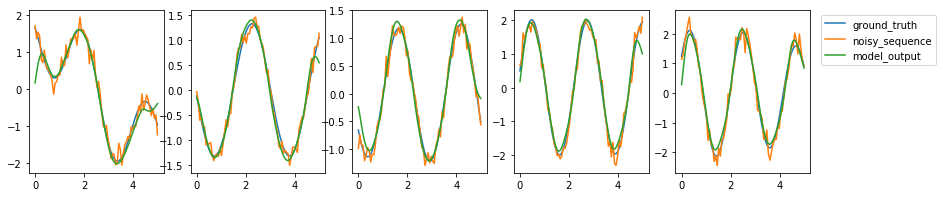

-4.1717% of noise removed.
epoch: 51, train loss:903.8505249023438
epoch: 51, validation loss:184.8339080810547
epoch: 52, train loss:882.4442749023438
epoch: 52, validation loss:177.76849365234375
epoch: 53, train loss:844.9138793945312
epoch: 53, validation loss:170.9945526123047
epoch: 54, train loss:798.54296875
epoch: 54, validation loss:168.7431640625
epoch: 55, train loss:769.0665283203125
epoch: 55, validation loss:168.630615234375
epoch: 56, train loss:754.8370361328125
epoch: 56, validation loss:165.43470764160156
epoch: 57, train loss:736.670166015625
epoch: 57, validation loss:159.92352294921875
epoch: 58, train loss:714.2142944335938
epoch: 58, validation loss:155.16163635253906
epoch: 59, train loss:694.4837036132812
epoch: 59, validation loss:152.0557403564453
epoch: 60, train loss:677.2211303710938
epoch: 60, validation loss:149.9622039794922


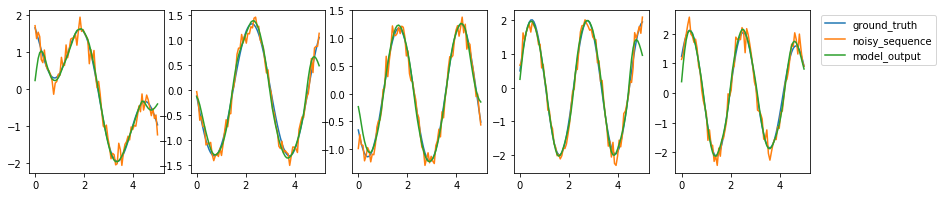

15.6047% of noise removed.
epoch: 61, train loss:659.4633178710938
epoch: 61, validation loss:148.6214141845703
epoch: 62, train loss:643.9957885742188
epoch: 62, validation loss:146.96629333496094
epoch: 63, train loss:630.8285522460938
epoch: 63, validation loss:144.1761474609375
epoch: 64, train loss:618.6050415039062
epoch: 64, validation loss:141.06333923339844
epoch: 65, train loss:609.007080078125
epoch: 65, validation loss:138.71078491210938
epoch: 66, train loss:602.2161254882812
epoch: 66, validation loss:136.92745971679688
epoch: 67, train loss:594.0581665039062
epoch: 67, validation loss:135.62261962890625
epoch: 68, train loss:584.4049682617188
epoch: 68, validation loss:135.1257781982422
epoch: 69, train loss:577.1504516601562
epoch: 69, validation loss:134.91285705566406
epoch: 70, train loss:572.4585571289062
epoch: 70, validation loss:134.28379821777344


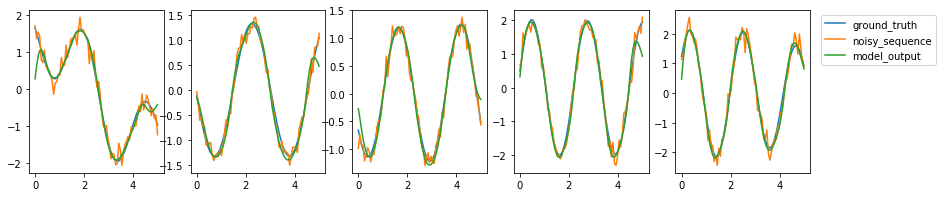

17.5026% of noise removed.
epoch: 71, train loss:568.2846069335938
epoch: 71, validation loss:133.21080017089844
epoch: 72, train loss:563.8604125976562
epoch: 72, validation loss:132.03855895996094
epoch: 73, train loss:559.382568359375
epoch: 73, validation loss:130.99656677246094
epoch: 74, train loss:554.8616943359375
epoch: 74, validation loss:130.14871215820312
epoch: 75, train loss:550.2536010742188
epoch: 75, validation loss:129.53033447265625
epoch: 76, train loss:545.9900512695312
epoch: 76, validation loss:129.08982849121094
epoch: 77, train loss:542.4505004882812
epoch: 77, validation loss:128.64926147460938
epoch: 78, train loss:539.4398803710938
epoch: 78, validation loss:128.05897521972656
epoch: 79, train loss:536.5866088867188
epoch: 79, validation loss:127.32173919677734
epoch: 80, train loss:533.8023681640625
epoch: 80, validation loss:126.5512924194336


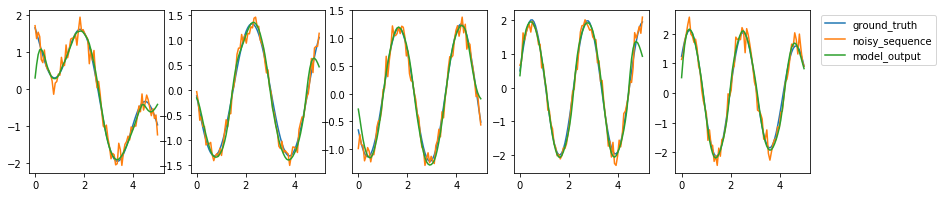

20.7090% of noise removed.
epoch: 81, train loss:531.2321166992188
epoch: 81, validation loss:125.8613510131836
epoch: 82, train loss:528.9942016601562
epoch: 82, validation loss:125.30142974853516
epoch: 83, train loss:527.0609741210938
epoch: 83, validation loss:124.86457824707031
epoch: 84, train loss:525.3265991210938
epoch: 84, validation loss:124.52364349365234
epoch: 85, train loss:523.7191772460938
epoch: 85, validation loss:124.2537841796875
epoch: 86, train loss:522.2346801757812
epoch: 86, validation loss:124.03487396240234
epoch: 87, train loss:520.8984985351562
epoch: 87, validation loss:123.84932708740234
epoch: 88, train loss:519.7265625
epoch: 88, validation loss:123.68285369873047
epoch: 89, train loss:518.7142944335938
epoch: 89, validation loss:123.52685546875
epoch: 90, train loss:517.8474731445312
epoch: 90, validation loss:123.3787612915039


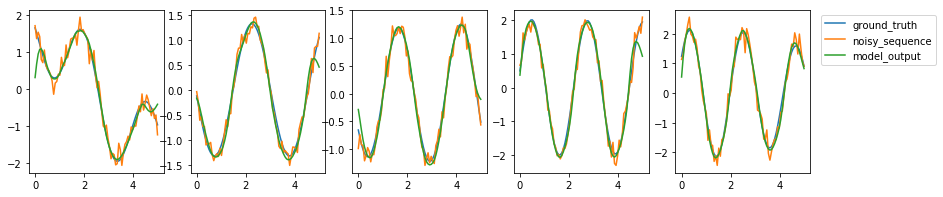

22.3944% of noise removed.
epoch: 91, train loss:517.1111450195312
epoch: 91, validation loss:123.24032592773438
epoch: 92, train loss:516.4931030273438
epoch: 92, validation loss:123.11502838134766
epoch: 93, train loss:515.9834594726562
epoch: 93, validation loss:123.00603485107422
epoch: 94, train loss:515.5720825195312
epoch: 94, validation loss:122.91524505615234
epoch: 95, train loss:515.24853515625
epoch: 95, validation loss:122.84303283691406
epoch: 96, train loss:515.0018310546875
epoch: 96, validation loss:122.7885513305664
epoch: 97, train loss:514.8213500976562
epoch: 97, validation loss:122.74998474121094
epoch: 98, train loss:514.6962280273438
epoch: 98, validation loss:122.72498321533203
epoch: 99, train loss:514.6163940429688
epoch: 99, validation loss:122.71074676513672
epoch: 100, train loss:514.5712890625
epoch: 100, validation loss:122.70439910888672


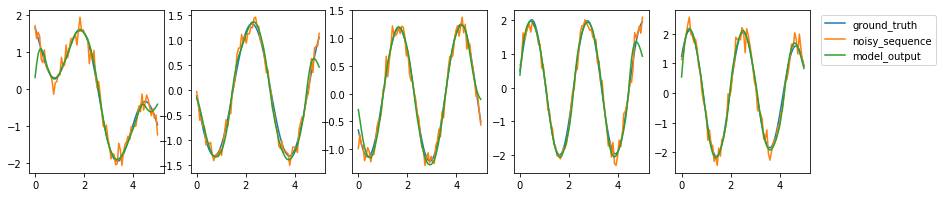

22.6862% of noise removed.


In [11]:
batch_size = 10
num_epochs = 101


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# this should remove ~32% of the noise
train(model, optimizer, scheduler, num_epochs, batch_size)

## Hyperparameter Optimization
As a preparation for next week's lecture, play with the model's hyperparameters and try to improve the amount of noise removed. List at least three different configurations you have tried and the respective percentage of noise removed. Make sure to always create a new model and that you train and validate on the same data!

| configuration        | Noise removed in percent |
| -------------------- | --------------------------: |
| initial configuration| 22.68%               |
| Hidden size 30, lr=0.001| Failed (-223.78%)               |
| Hidden size 50, lr=0.01| 19.33%               |
| Hidden size 80, lr=0.01| 27.36%               |

Testing with params: [Hidden-Size: 30, Shift: 10, Learning-Rate: 0.001]
epoch: 0, train loss:24112.4296875
epoch: 0, validation loss:5539.61767578125


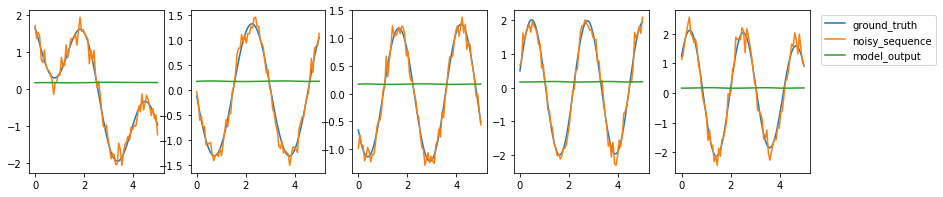

-650.6701% of noise removed.
epoch: 1, train loss:23969.244140625
epoch: 1, validation loss:5505.39013671875
epoch: 2, train loss:23831.970703125
epoch: 2, validation loss:5472.396484375
epoch: 3, train loss:23699.41015625
epoch: 3, validation loss:5440.28955078125
epoch: 4, train loss:23570.0546875
epoch: 4, validation loss:5408.74072265625
epoch: 5, train loss:23442.5
epoch: 5, validation loss:5377.4580078125
epoch: 6, train loss:23315.474609375
epoch: 6, validation loss:5346.1767578125
epoch: 7, train loss:23187.86328125
epoch: 7, validation loss:5314.6552734375
epoch: 8, train loss:23058.59375
epoch: 8, validation loss:5282.6591796875
epoch: 9, train loss:22926.6328125
epoch: 9, validation loss:5249.951171875
epoch: 10, train loss:22790.970703125
epoch: 10, validation loss:5216.29248046875


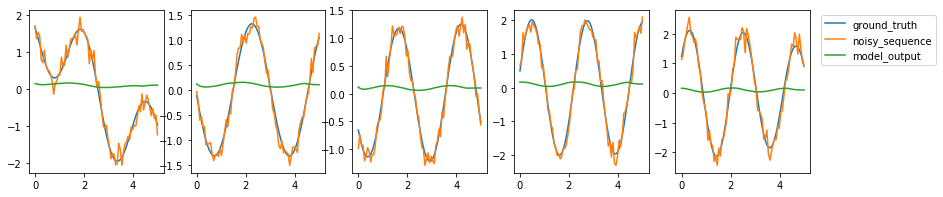

-626.8580% of noise removed.
epoch: 11, train loss:22650.517578125
epoch: 11, validation loss:5181.41650390625
epoch: 12, train loss:22504.130859375
epoch: 12, validation loss:5145.037109375
epoch: 13, train loss:22350.537109375
epoch: 13, validation loss:5106.8359375
epoch: 14, train loss:22188.375
epoch: 14, validation loss:5066.4677734375
epoch: 15, train loss:22016.130859375
epoch: 15, validation loss:5023.55712890625
epoch: 16, train loss:21832.205078125
epoch: 16, validation loss:4977.7001953125
epoch: 17, train loss:21634.8203125
epoch: 17, validation loss:4928.45556640625
epoch: 18, train loss:21422.080078125
epoch: 18, validation loss:4875.34619140625
epoch: 19, train loss:21191.947265625
epoch: 19, validation loss:4817.85205078125
epoch: 20, train loss:20942.189453125
epoch: 20, validation loss:4755.408203125


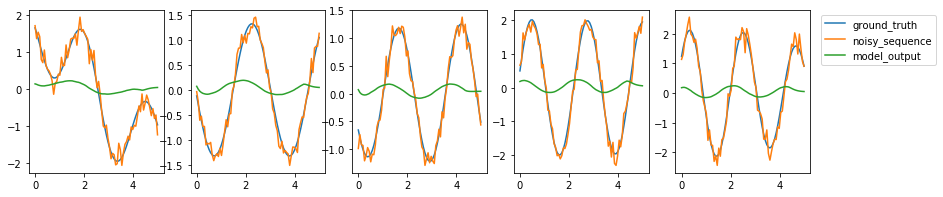

-592.6469% of noise removed.
epoch: 21, train loss:20670.41015625
epoch: 21, validation loss:4687.40478515625
epoch: 22, train loss:20374.033203125
epoch: 22, validation loss:4613.18212890625
epoch: 23, train loss:20050.33203125
epoch: 23, validation loss:4532.05224609375
epoch: 24, train loss:19696.447265625
epoch: 24, validation loss:4443.29248046875
epoch: 25, train loss:19309.451171875
epoch: 25, validation loss:4346.1767578125
epoch: 26, train loss:18886.447265625
epoch: 26, validation loss:4240.00390625
epoch: 27, train loss:18424.70703125
epoch: 27, validation loss:4124.138671875
epoch: 28, train loss:17921.841796875
epoch: 28, validation loss:3998.053466796875
epoch: 29, train loss:17376.013671875
epoch: 29, validation loss:3861.391845703125
epoch: 30, train loss:16786.150390625
epoch: 30, validation loss:3714.025634765625


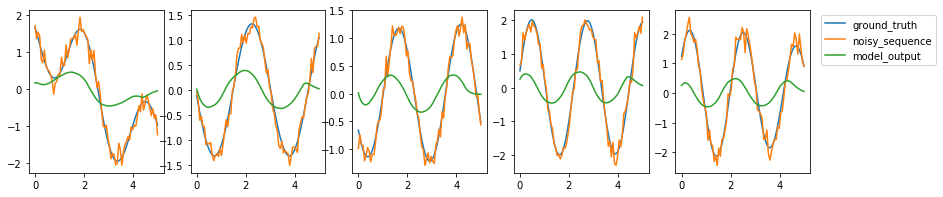

-505.6146% of noise removed.
epoch: 31, train loss:16152.17578125
epoch: 31, validation loss:3556.115478515625
epoch: 32, train loss:15475.2685546875
epoch: 32, validation loss:3388.17919921875
epoch: 33, train loss:14758.0908203125
epoch: 33, validation loss:3211.146484375
epoch: 34, train loss:14004.998046875
epoch: 34, validation loss:3026.416259765625
epoch: 35, train loss:13222.2509765625
epoch: 35, validation loss:2835.88623046875
epoch: 36, train loss:12418.1435546875
epoch: 36, validation loss:2641.972412109375
epoch: 37, train loss:11603.03125
epoch: 37, validation loss:2447.585693359375
epoch: 38, train loss:10789.234375
epoch: 38, validation loss:2256.0751953125
epoch: 39, train loss:9990.740234375
epoch: 39, validation loss:2071.129150390625
epoch: 40, train loss:9222.689453125
epoch: 40, validation loss:1896.625


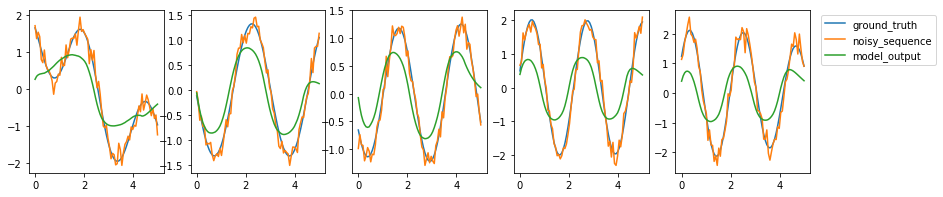

-300.4495% of noise removed.
epoch: 41, train loss:8500.712890625
epoch: 41, validation loss:1736.431396484375
epoch: 42, train loss:7840.046875
epoch: 42, validation loss:1594.16064453125
epoch: 43, train loss:7254.58203125
epoch: 43, validation loss:1472.8883056640625
epoch: 44, train loss:6755.80419921875
epoch: 44, validation loss:1374.8643798828125
epoch: 45, train loss:6351.77978515625
epoch: 45, validation loss:1301.2613525390625
epoch: 46, train loss:6046.16015625
epoch: 46, validation loss:1251.9879150390625
epoch: 47, train loss:5837.34765625
epoch: 47, validation loss:1225.568115234375
epoch: 48, train loss:5717.8291015625
epoch: 48, validation loss:1219.06884765625
epoch: 49, train loss:5674.01220703125
epoch: 49, validation loss:1228.1611328125
epoch: 50, train loss:5687.20458984375
epoch: 50, validation loss:1247.5047607421875


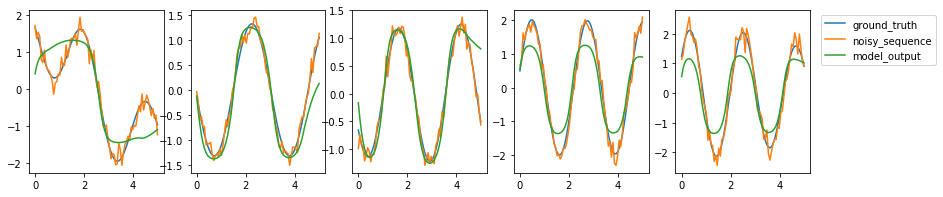

-253.3284% of noise removed.
epoch: 51, train loss:5736.2109375
epoch: 51, validation loss:1271.445556640625
epoch: 52, train loss:5800.626953125
epoch: 52, validation loss:1294.72314453125
epoch: 53, train loss:5863.3291015625
epoch: 53, validation loss:1313.095458984375
epoch: 54, train loss:5911.6181640625
epoch: 54, validation loss:1323.916748046875
epoch: 55, train loss:5937.70166015625
epoch: 55, validation loss:1326.3050537109375
epoch: 56, train loss:5938.77685546875
epoch: 56, validation loss:1320.8173828125
epoch: 57, train loss:5916.22705078125
epoch: 57, validation loss:1308.919677734375
epoch: 58, train loss:5874.16455078125
epoch: 58, validation loss:1292.461181640625
epoch: 59, train loss:5817.91796875
epoch: 59, validation loss:1273.28515625
epoch: 60, train loss:5752.86962890625
epoch: 60, validation loss:1252.987060546875


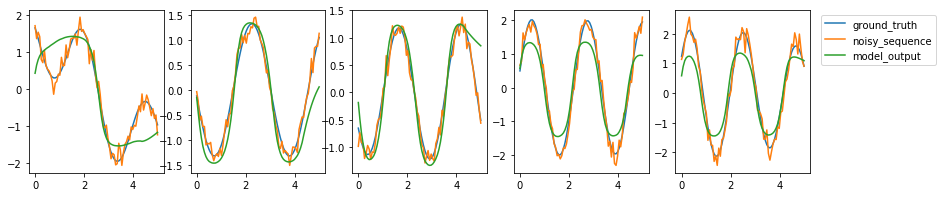

-261.4594% of noise removed.
epoch: 61, train loss:5683.76416015625
epoch: 61, validation loss:1232.8165283203125
epoch: 62, train loss:5614.40673828125
epoch: 62, validation loss:1213.6556396484375
epoch: 63, train loss:5547.6044921875
epoch: 63, validation loss:1196.06005859375
epoch: 64, train loss:5485.24169921875
epoch: 64, validation loss:1180.315673828125
epoch: 65, train loss:5428.42724609375
epoch: 65, validation loss:1166.5072021484375
epoch: 66, train loss:5377.64208984375
epoch: 66, validation loss:1154.5772705078125
epoch: 67, train loss:5332.90185546875
epoch: 67, validation loss:1144.378173828125
epoch: 68, train loss:5293.89599609375
epoch: 68, validation loss:1135.7122802734375
epoch: 69, train loss:5260.10791015625
epoch: 69, validation loss:1128.36376953125
epoch: 70, train loss:5230.91748046875
epoch: 70, validation loss:1122.118896484375


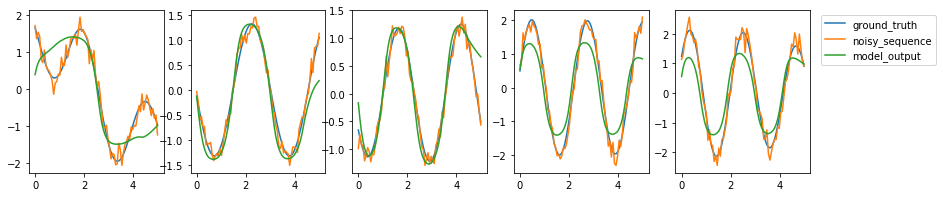

-235.2608% of noise removed.
epoch: 71, train loss:5205.67138671875
epoch: 71, validation loss:1116.7803955078125
epoch: 72, train loss:5183.7412109375
epoch: 72, validation loss:1112.1754150390625
epoch: 73, train loss:5164.55615234375
epoch: 73, validation loss:1108.1580810546875
epoch: 74, train loss:5147.62255859375
epoch: 74, validation loss:1104.60986328125
epoch: 75, train loss:5132.5283203125
epoch: 75, validation loss:1101.4384765625
epoch: 76, train loss:5118.94140625
epoch: 76, validation loss:1098.5732421875
epoch: 77, train loss:5106.607421875
epoch: 77, validation loss:1095.9613037109375
epoch: 78, train loss:5095.328125
epoch: 78, validation loss:1093.5657958984375
epoch: 79, train loss:5084.96240234375
epoch: 79, validation loss:1091.3602294921875
epoch: 80, train loss:5075.4072265625
epoch: 80, validation loss:1089.3265380859375


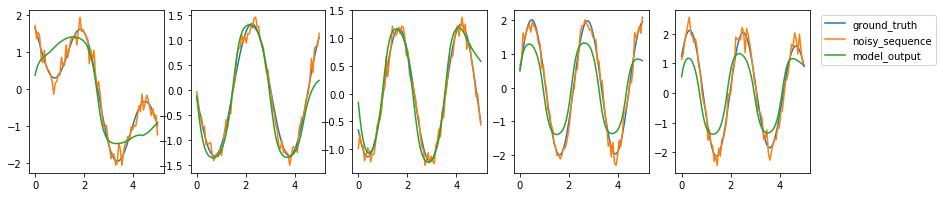

-226.7869% of noise removed.
epoch: 81, train loss:5066.59130859375
epoch: 81, validation loss:1087.452392578125
epoch: 82, train loss:5058.46337890625
epoch: 82, validation loss:1085.730224609375
epoch: 83, train loss:5050.98876953125
epoch: 83, validation loss:1084.153564453125
epoch: 84, train loss:5044.14404296875
epoch: 84, validation loss:1082.7181396484375
epoch: 85, train loss:5037.90625
epoch: 85, validation loss:1081.4195556640625
epoch: 86, train loss:5032.25927734375
epoch: 86, validation loss:1080.25390625
epoch: 87, train loss:5027.1845703125
epoch: 87, validation loss:1079.2166748046875
epoch: 88, train loss:5022.6630859375
epoch: 88, validation loss:1078.302490234375
epoch: 89, train loss:5018.673828125
epoch: 89, validation loss:1077.506103515625
epoch: 90, train loss:5015.1943359375
epoch: 90, validation loss:1076.8209228515625


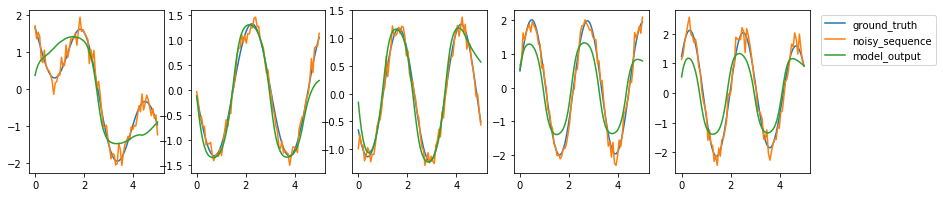

-224.1969% of noise removed.
epoch: 91, train loss:5012.1962890625
epoch: 91, validation loss:1076.2401123046875
epoch: 92, train loss:5009.65380859375
epoch: 92, validation loss:1075.7567138671875
epoch: 93, train loss:5007.53173828125
epoch: 93, validation loss:1075.3621826171875
epoch: 94, train loss:5005.80078125
epoch: 94, validation loss:1075.0484619140625
epoch: 95, train loss:5004.421875
epoch: 95, validation loss:1074.8067626953125
epoch: 96, train loss:5003.35986328125
epoch: 96, validation loss:1074.6285400390625
epoch: 97, train loss:5002.57373046875
epoch: 97, validation loss:1074.50390625
epoch: 98, train loss:5002.02587890625
epoch: 98, validation loss:1074.4239501953125
epoch: 99, train loss:5001.673828125
epoch: 99, validation loss:1074.37890625
epoch: 100, train loss:5001.4736328125
epoch: 100, validation loss:1074.3583984375


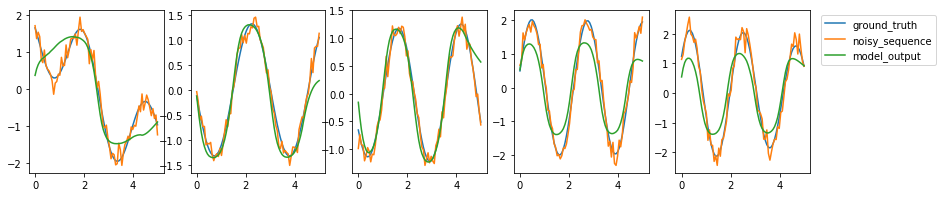

-223.7844% of noise removed.
Testing with params: [Hidden-Size: 50, Shift: 10, Learning-Rate: 0.01]
epoch: 0, train loss:23760.76171875
epoch: 0, validation loss:5049.4619140625


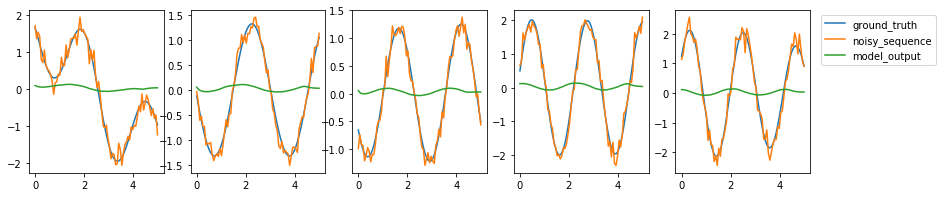

-614.1906% of noise removed.
epoch: 1, train loss:21997.125
epoch: 1, validation loss:4383.7939453125
epoch: 2, train loss:19068.505859375
epoch: 2, validation loss:2855.826904296875
epoch: 3, train loss:12409.525390625
epoch: 3, validation loss:1259.50830078125
epoch: 4, train loss:5861.93603515625
epoch: 4, validation loss:3771.11328125
epoch: 5, train loss:14322.8857421875
epoch: 5, validation loss:3436.17431640625
epoch: 6, train loss:14027.48046875
epoch: 6, validation loss:1774.1712646484375
epoch: 7, train loss:7924.59521484375
epoch: 7, validation loss:1640.737548828125
epoch: 8, train loss:7298.91015625
epoch: 8, validation loss:1974.7412109375
epoch: 9, train loss:8598.6953125
epoch: 9, validation loss:2245.7900390625
epoch: 10, train loss:9717.5302734375
epoch: 10, validation loss:2356.371826171875


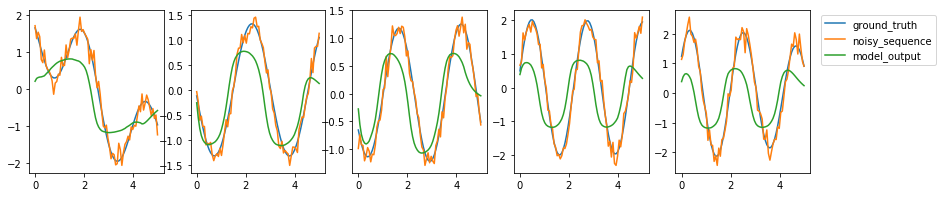

-368.8515% of noise removed.
epoch: 11, train loss:10209.28125
epoch: 11, validation loss:2334.372314453125
epoch: 12, train loss:10160.189453125
epoch: 12, validation loss:2218.230712890625
epoch: 13, train loss:9720.5771484375
epoch: 13, validation loss:2042.4622802734375
epoch: 14, train loss:9033.5673828125
epoch: 14, validation loss:1844.9508056640625
epoch: 15, train loss:8250.01171875
epoch: 15, validation loss:1662.26953125
epoch: 16, train loss:7531.70849609375
epoch: 16, validation loss:1547.033935546875
epoch: 17, train loss:7058.388671875
epoch: 17, validation loss:1537.6080322265625
epoch: 18, train loss:6888.6357421875
epoch: 18, validation loss:1586.7940673828125
epoch: 19, train loss:6950.86572265625
epoch: 19, validation loss:1620.433349609375
epoch: 20, train loss:7035.05322265625
epoch: 20, validation loss:1550.4268798828125


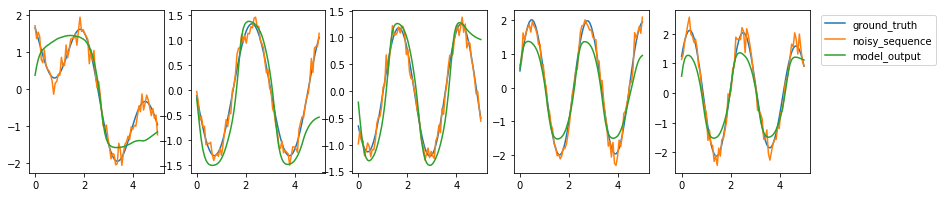

-307.1354% of noise removed.
epoch: 21, train loss:6821.87744140625
epoch: 21, validation loss:1411.576904296875
epoch: 22, train loss:6290.24609375
epoch: 22, validation loss:1263.8721923828125
epoch: 23, train loss:5645.30322265625
epoch: 23, validation loss:1115.916748046875
epoch: 24, train loss:5058.81591796875
epoch: 24, validation loss:1007.8967895507812
epoch: 25, train loss:4623.119140625
epoch: 25, validation loss:947.477783203125
epoch: 26, train loss:4358.8046875
epoch: 26, validation loss:918.8899536132812
epoch: 27, train loss:4209.78173828125
epoch: 27, validation loss:884.9883422851562
epoch: 28, train loss:4030.221435546875
epoch: 28, validation loss:815.750244140625
epoch: 29, train loss:3707.08447265625
epoch: 29, validation loss:737.4887084960938
epoch: 30, train loss:3358.187255859375
epoch: 30, validation loss:710.8544921875


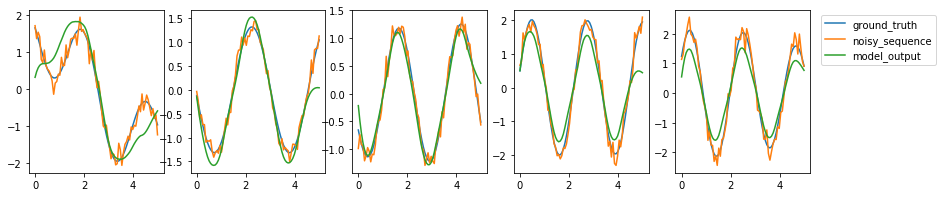

-153.8985% of noise removed.
epoch: 31, train loss:3239.804443359375
epoch: 31, validation loss:711.9842529296875
epoch: 32, train loss:3239.9326171875
epoch: 32, validation loss:660.3751831054688
epoch: 33, train loss:3016.04296875
epoch: 33, validation loss:595.2430419921875
epoch: 34, train loss:2748.148681640625
epoch: 34, validation loss:584.7493286132812
epoch: 35, train loss:2696.309814453125
epoch: 35, validation loss:596.907958984375
epoch: 36, train loss:2704.91845703125
epoch: 36, validation loss:583.8300170898438
epoch: 37, train loss:2607.8681640625
epoch: 37, validation loss:550.3167724609375
epoch: 38, train loss:2461.843505859375
epoch: 38, validation loss:497.7493591308594
epoch: 39, train loss:2301.34912109375
epoch: 39, validation loss:447.6142272949219
epoch: 40, train loss:2176.53271484375
epoch: 40, validation loss:413.4123840332031


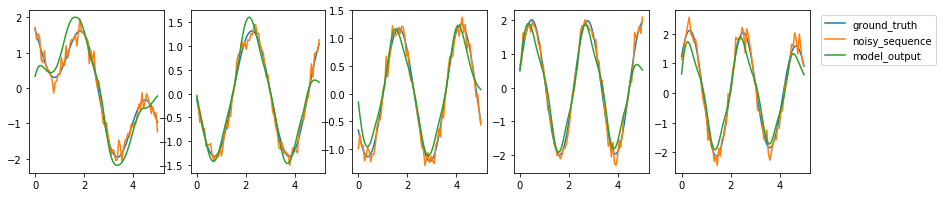

-79.8373% of noise removed.
epoch: 41, train loss:2072.782958984375
epoch: 41, validation loss:384.5154724121094
epoch: 42, train loss:1923.17578125
epoch: 42, validation loss:373.65533447265625
epoch: 43, train loss:1814.1033935546875
epoch: 43, validation loss:360.7318420410156
epoch: 44, train loss:1722.27587890625
epoch: 44, validation loss:333.15899658203125
epoch: 45, train loss:1606.705322265625
epoch: 45, validation loss:309.01287841796875
epoch: 46, train loss:1510.65478515625
epoch: 46, validation loss:290.2810974121094
epoch: 47, train loss:1426.140625
epoch: 47, validation loss:273.9183349609375
epoch: 48, train loss:1344.2852783203125
epoch: 48, validation loss:257.3108215332031
epoch: 49, train loss:1263.440673828125
epoch: 49, validation loss:241.48428344726562
epoch: 50, train loss:1191.880615234375
epoch: 50, validation loss:234.1361083984375


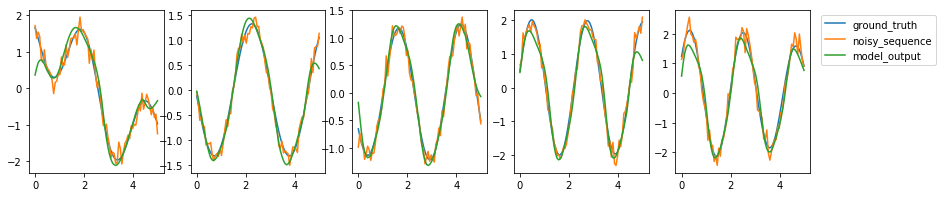

-15.9333% of noise removed.
epoch: 51, train loss:1152.292724609375
epoch: 51, validation loss:226.9829864501953
epoch: 52, train loss:1100.25927734375
epoch: 52, validation loss:216.49490356445312
epoch: 53, train loss:1025.09521484375
epoch: 53, validation loss:207.7384490966797
epoch: 54, train loss:962.3095703125
epoch: 54, validation loss:200.706298828125
epoch: 55, train loss:918.5138549804688
epoch: 55, validation loss:195.26715087890625
epoch: 56, train loss:883.3463745117188
epoch: 56, validation loss:187.86683654785156
epoch: 57, train loss:837.4166870117188
epoch: 57, validation loss:182.33639526367188
epoch: 58, train loss:801.8159790039062
epoch: 58, validation loss:176.77285766601562
epoch: 59, train loss:776.0718383789062
epoch: 59, validation loss:169.60769653320312
epoch: 60, train loss:749.239990234375
epoch: 60, validation loss:164.2766876220703


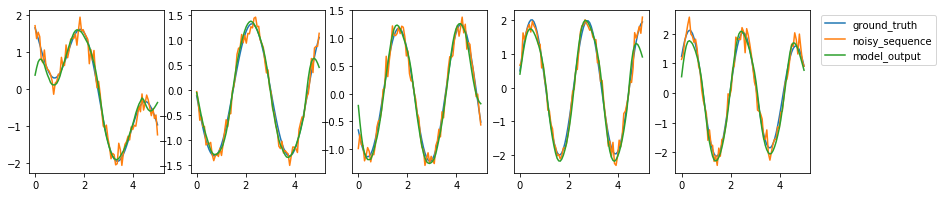

3.5669% of noise removed.
epoch: 61, train loss:723.9249877929688
epoch: 61, validation loss:161.6247100830078
epoch: 62, train loss:700.9559326171875
epoch: 62, validation loss:159.90684509277344
epoch: 63, train loss:681.0693969726562
epoch: 63, validation loss:156.7012939453125
epoch: 64, train loss:662.3563232421875
epoch: 64, validation loss:154.97463989257812
epoch: 65, train loss:652.9301147460938
epoch: 65, validation loss:153.39642333984375
epoch: 66, train loss:641.9163208007812
epoch: 66, validation loss:151.50830078125
epoch: 67, train loss:629.0703125
epoch: 67, validation loss:148.8291778564453
epoch: 68, train loss:617.9628295898438
epoch: 68, validation loss:146.1701202392578
epoch: 69, train loss:610.39208984375
epoch: 69, validation loss:144.1060791015625
epoch: 70, train loss:603.41650390625
epoch: 70, validation loss:142.64883422851562


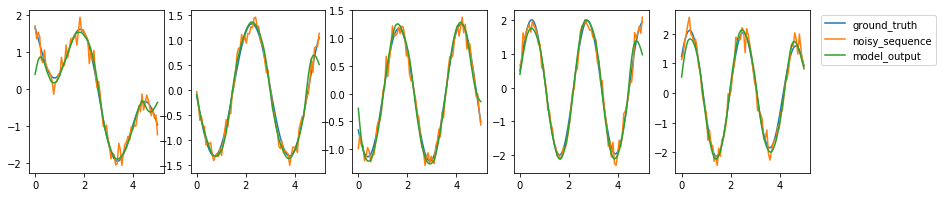

14.7814% of noise removed.
epoch: 71, train loss:596.0634765625
epoch: 71, validation loss:142.0044708251953
epoch: 72, train loss:591.290283203125
epoch: 72, validation loss:141.02391052246094
epoch: 73, train loss:585.964599609375
epoch: 73, validation loss:139.71652221679688
epoch: 74, train loss:579.6287841796875
epoch: 74, validation loss:138.92543029785156
epoch: 75, train loss:574.783203125
epoch: 75, validation loss:138.58444213867188
epoch: 76, train loss:571.103759765625
epoch: 76, validation loss:138.3295440673828
epoch: 77, train loss:567.7220458984375
epoch: 77, validation loss:137.89149475097656
epoch: 78, train loss:564.41943359375
epoch: 78, validation loss:137.17892456054688
epoch: 79, train loss:561.2676391601562
epoch: 79, validation loss:136.37937927246094
epoch: 80, train loss:558.5942993164062
epoch: 80, validation loss:135.67686462402344


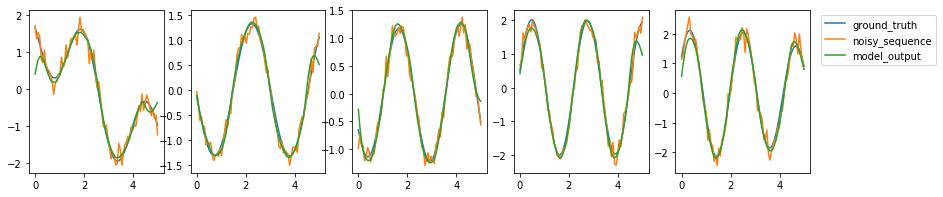

18.5301% of noise removed.
epoch: 81, train loss:556.3408203125
epoch: 81, validation loss:135.0990447998047
epoch: 82, train loss:554.1380004882812
epoch: 82, validation loss:134.64564514160156
epoch: 83, train loss:551.9874267578125
epoch: 83, validation loss:134.321533203125
epoch: 84, train loss:550.1641845703125
epoch: 84, validation loss:134.0767059326172
epoch: 85, train loss:548.720947265625
epoch: 85, validation loss:133.83465576171875
epoch: 86, train loss:547.4713134765625
epoch: 86, validation loss:133.5627899169922
epoch: 87, train loss:546.2716674804688
epoch: 87, validation loss:133.2820281982422
epoch: 88, train loss:545.12451171875
epoch: 88, validation loss:133.02767944335938
epoch: 89, train loss:544.0900268554688
epoch: 89, validation loss:132.82044982910156
epoch: 90, train loss:543.2014770507812
epoch: 90, validation loss:132.6630401611328


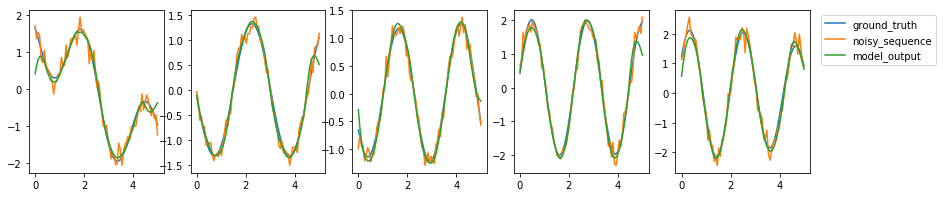

19.0755% of noise removed.
epoch: 91, train loss:542.4555053710938
epoch: 91, validation loss:132.54835510253906
epoch: 92, train loss:541.834228515625
epoch: 92, validation loss:132.466796875
epoch: 93, train loss:541.3211059570312
epoch: 93, validation loss:132.4094696044922
epoch: 94, train loss:540.9041137695312
epoch: 94, validation loss:132.36932373046875
epoch: 95, train loss:540.5733032226562
epoch: 95, validation loss:132.34115600585938
epoch: 96, train loss:540.3189697265625
epoch: 96, validation loss:132.3214111328125
epoch: 97, train loss:540.13134765625
epoch: 97, validation loss:132.30796813964844
epoch: 98, train loss:540.0004272460938
epoch: 98, validation loss:132.2992706298828
epoch: 99, train loss:539.9163208007812
epoch: 99, validation loss:132.29428100585938
epoch: 100, train loss:539.8685913085938
epoch: 100, validation loss:132.29196166992188


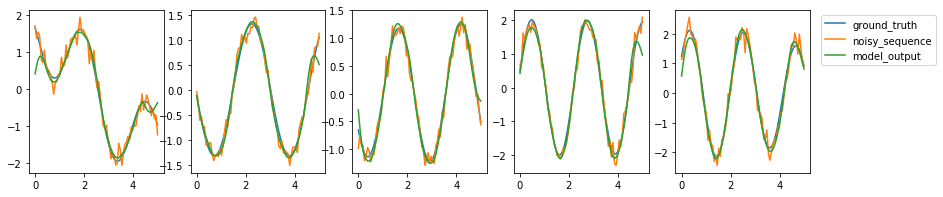

19.3315% of noise removed.
Testing with params: [Hidden-Size: 80, Shift: 10, Learning-Rate: 0.01]
epoch: 0, train loss:23234.658203125
epoch: 0, validation loss:4619.9306640625


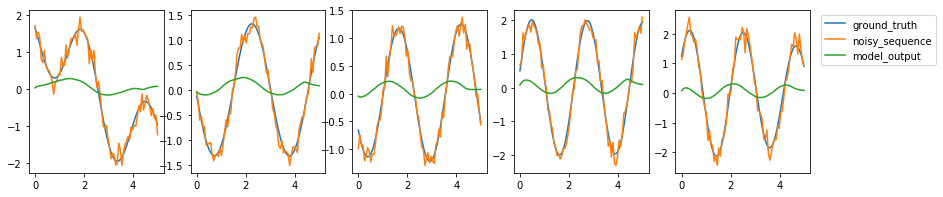

-583.7975% of noise removed.
epoch: 1, train loss:19957.755859375
epoch: 1, validation loss:2049.751708984375
epoch: 2, train loss:8757.1015625
epoch: 2, validation loss:4525.26416015625
epoch: 3, train loss:18373.1171875
epoch: 3, validation loss:2390.119140625
epoch: 4, train loss:9027.6357421875
epoch: 4, validation loss:1902.3623046875
epoch: 5, train loss:7813.12646484375
epoch: 5, validation loss:2276.63037109375
epoch: 6, train loss:9586.5390625
epoch: 6, validation loss:2494.439208984375
epoch: 7, train loss:10579.1337890625
epoch: 7, validation loss:2489.189453125
epoch: 8, train loss:10619.033203125
epoch: 8, validation loss:2286.4638671875
epoch: 9, train loss:9836.2158203125
epoch: 9, validation loss:1949.9931640625
epoch: 10, train loss:8461.3837890625
epoch: 10, validation loss:1687.2181396484375


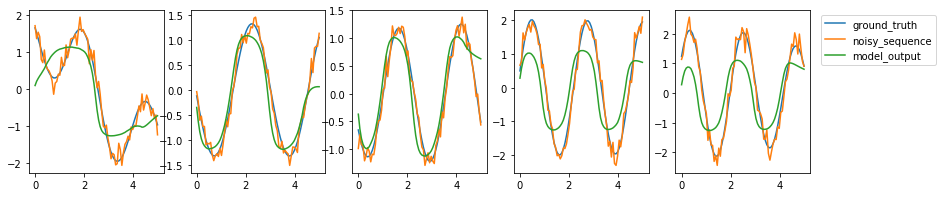

-306.4166% of noise removed.
epoch: 11, train loss:7230.56494140625
epoch: 11, validation loss:1881.9161376953125
epoch: 12, train loss:7665.23779296875
epoch: 12, validation loss:1891.703857421875
epoch: 13, train loss:7636.0283203125
epoch: 13, validation loss:1673.52099609375
epoch: 14, train loss:6971.7783203125
epoch: 14, validation loss:1641.6861572265625
epoch: 15, train loss:7069.19384765625
epoch: 15, validation loss:1383.8602294921875
epoch: 16, train loss:5943.6953125
epoch: 16, validation loss:1202.5906982421875
epoch: 17, train loss:5198.24755859375
epoch: 17, validation loss:1171.813232421875
epoch: 18, train loss:5004.67529296875
epoch: 18, validation loss:1085.946044921875
epoch: 19, train loss:4655.6904296875
epoch: 19, validation loss:933.0925903320312
epoch: 20, train loss:4110.40869140625
epoch: 20, validation loss:831.535400390625


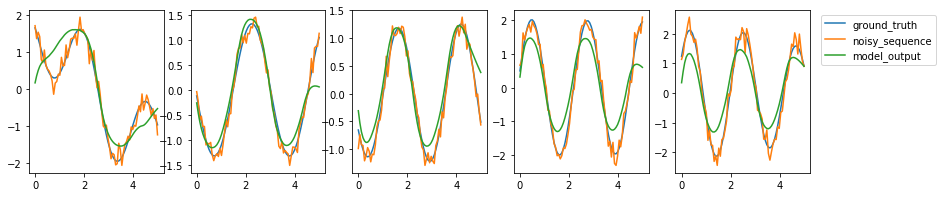

-172.5539% of noise removed.
epoch: 21, train loss:3776.69140625
epoch: 21, validation loss:822.603271484375
epoch: 22, train loss:3690.660888671875
epoch: 22, validation loss:790.3048706054688
epoch: 23, train loss:3366.09228515625
epoch: 23, validation loss:691.6633911132812
epoch: 24, train loss:2956.93408203125
epoch: 24, validation loss:695.7681274414062
epoch: 25, train loss:2979.64697265625
epoch: 25, validation loss:592.8286743164062
epoch: 26, train loss:2571.689697265625
epoch: 26, validation loss:546.3062744140625
epoch: 27, train loss:2432.0166015625
epoch: 27, validation loss:514.7645874023438
epoch: 28, train loss:2292.63916015625
epoch: 28, validation loss:426.51776123046875
epoch: 29, train loss:1879.9930419921875
epoch: 29, validation loss:439.9300231933594
epoch: 30, train loss:1930.84521484375
epoch: 30, validation loss:364.445556640625


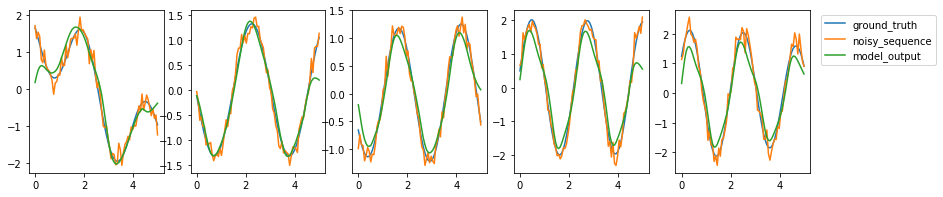

-61.4633% of noise removed.
epoch: 31, train loss:1642.91455078125
epoch: 31, validation loss:324.8769836425781
epoch: 32, train loss:1508.3251953125
epoch: 32, validation loss:323.7637939453125
epoch: 33, train loss:1461.8963623046875
epoch: 33, validation loss:280.5146789550781
epoch: 34, train loss:1255.9063720703125
epoch: 34, validation loss:278.6361999511719
epoch: 35, train loss:1267.475341796875
epoch: 35, validation loss:244.18130493164062
epoch: 36, train loss:1120.671142578125
epoch: 36, validation loss:229.78907775878906
epoch: 37, train loss:1043.50537109375
epoch: 37, validation loss:239.94198608398438
epoch: 38, train loss:1051.6240234375
epoch: 38, validation loss:205.35812377929688
epoch: 39, train loss:903.554931640625
epoch: 39, validation loss:213.3154296875
epoch: 40, train loss:940.10009765625
epoch: 40, validation loss:200.64198303222656


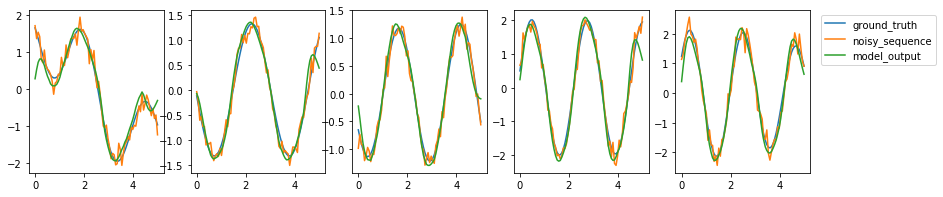

-14.4460% of noise removed.
epoch: 41, train loss:843.3750610351562
epoch: 41, validation loss:212.43995666503906
epoch: 42, train loss:844.2508544921875
epoch: 42, validation loss:189.28334045410156
epoch: 43, train loss:766.6544799804688
epoch: 43, validation loss:179.5055694580078
epoch: 44, train loss:767.4855346679688
epoch: 44, validation loss:169.6609649658203
epoch: 45, train loss:716.6149291992188
epoch: 45, validation loss:168.35511779785156
epoch: 46, train loss:674.3726196289062
epoch: 46, validation loss:168.11769104003906
epoch: 47, train loss:662.383544921875
epoch: 47, validation loss:154.37686157226562
epoch: 48, train loss:626.077880859375
epoch: 48, validation loss:151.93154907226562
epoch: 49, train loss:626.2332763671875
epoch: 49, validation loss:142.2268829345703
epoch: 50, train loss:583.6371459960938
epoch: 50, validation loss:147.13426208496094


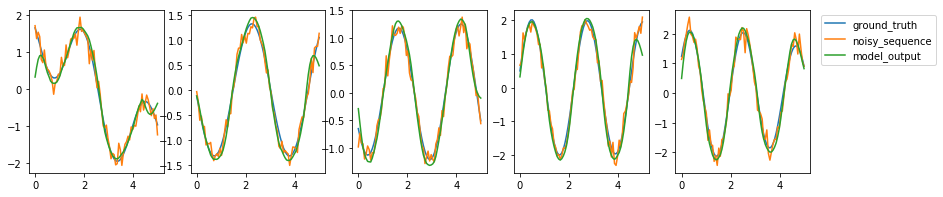

5.5218% of noise removed.
epoch: 51, train loss:596.60595703125
epoch: 51, validation loss:138.15313720703125
epoch: 52, train loss:567.2237548828125
epoch: 52, validation loss:135.2407684326172
epoch: 53, train loss:561.7418212890625
epoch: 53, validation loss:133.64398193359375
epoch: 54, train loss:551.0350341796875
epoch: 54, validation loss:132.84814453125
epoch: 55, train loss:538.8237915039062
epoch: 55, validation loss:134.82501220703125
epoch: 56, train loss:542.4844360351562
epoch: 56, validation loss:128.33766174316406
epoch: 57, train loss:521.7826538085938
epoch: 57, validation loss:126.33354187011719
epoch: 58, train loss:519.7489624023438
epoch: 58, validation loss:124.3598403930664
epoch: 59, train loss:512.7489013671875
epoch: 59, validation loss:122.62989807128906
epoch: 60, train loss:502.565673828125
epoch: 60, validation loss:123.22696685791016


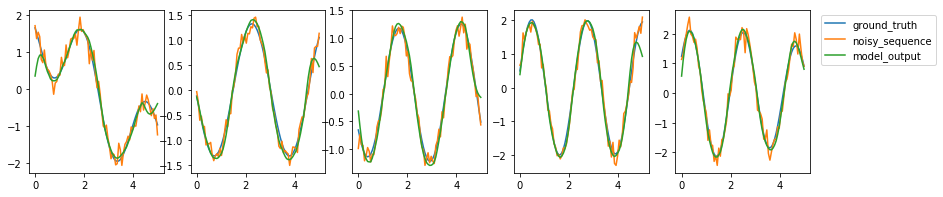

20.1333% of noise removed.
epoch: 61, train loss:501.25128173828125
epoch: 61, validation loss:120.4706039428711
epoch: 62, train loss:489.5427551269531
epoch: 62, validation loss:119.22566223144531
epoch: 63, train loss:485.2182312011719
epoch: 63, validation loss:118.98943328857422
epoch: 64, train loss:483.31060791015625
epoch: 64, validation loss:117.40734100341797
epoch: 65, train loss:475.0291442871094
epoch: 65, validation loss:116.87673950195312
epoch: 66, train loss:471.35699462890625
epoch: 66, validation loss:116.1122055053711
epoch: 67, train loss:468.063720703125
epoch: 67, validation loss:114.40277862548828
epoch: 68, train loss:462.6190490722656
epoch: 68, validation loss:113.5794448852539
epoch: 69, train loss:460.53363037109375
epoch: 69, validation loss:113.12799072265625
epoch: 70, train loss:458.2101745605469
epoch: 70, validation loss:112.51953887939453


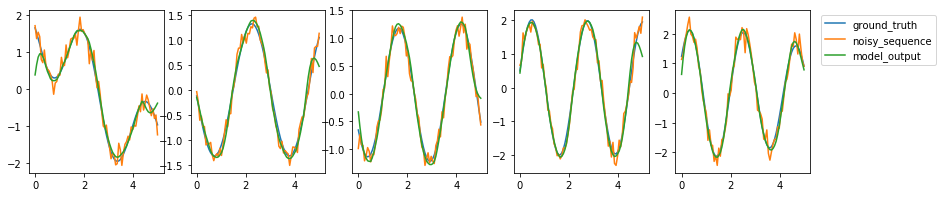

25.6849% of noise removed.
epoch: 71, train loss:453.9814453125
epoch: 71, validation loss:112.4521484375
epoch: 72, train loss:451.5350036621094
epoch: 72, validation loss:112.5369644165039
epoch: 73, train loss:450.1890563964844
epoch: 73, validation loss:112.0992660522461
epoch: 74, train loss:447.9493103027344
epoch: 74, validation loss:111.43657684326172
epoch: 75, train loss:445.7176513671875
epoch: 75, validation loss:110.91973114013672
epoch: 76, train loss:444.1583251953125
epoch: 76, validation loss:110.4630355834961
epoch: 77, train loss:442.60009765625
epoch: 77, validation loss:109.99888610839844
epoch: 78, train loss:440.8889465332031
epoch: 78, validation loss:109.62580871582031
epoch: 79, train loss:439.49334716796875
epoch: 79, validation loss:109.36695861816406
epoch: 80, train loss:438.4923400878906
epoch: 80, validation loss:109.13396453857422


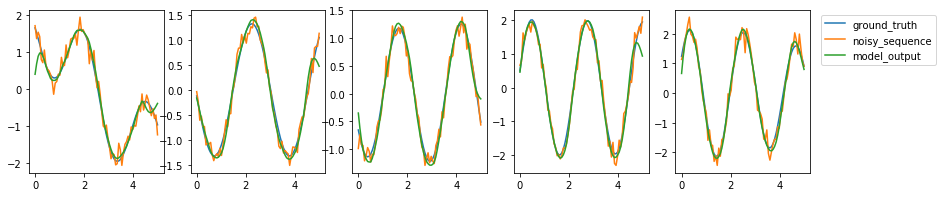

26.0751% of noise removed.
epoch: 81, train loss:437.55975341796875
epoch: 81, validation loss:108.87635040283203
epoch: 82, train loss:436.5223083496094
epoch: 82, validation loss:108.62982940673828
epoch: 83, train loss:435.4898376464844
epoch: 83, validation loss:108.44200134277344
epoch: 84, train loss:434.6083679199219
epoch: 84, validation loss:108.31607055664062
epoch: 85, train loss:433.8982849121094
epoch: 85, validation loss:108.22264099121094
epoch: 86, train loss:433.296142578125
epoch: 86, validation loss:108.1341323852539
epoch: 87, train loss:432.7462158203125
epoch: 87, validation loss:108.04012298583984
epoch: 88, train loss:432.235107421875
epoch: 88, validation loss:107.94294738769531
epoch: 89, train loss:431.7749938964844
epoch: 89, validation loss:107.84834289550781
epoch: 90, train loss:431.3779296875
epoch: 90, validation loss:107.7604751586914


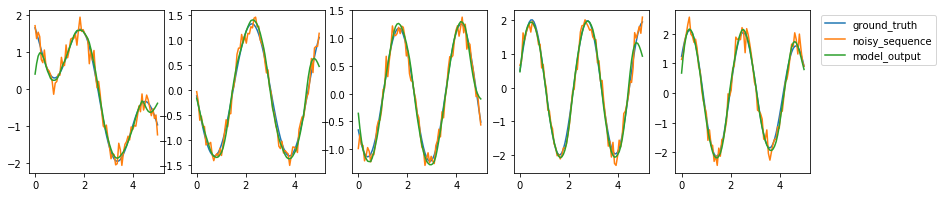

27.0682% of noise removed.
epoch: 91, train loss:431.0458984375
epoch: 91, validation loss:107.68135833740234
epoch: 92, train loss:430.77239990234375
epoch: 92, validation loss:107.6118392944336
epoch: 93, train loss:430.5483703613281
epoch: 93, validation loss:107.55241394042969
epoch: 94, train loss:430.3664245605469
epoch: 94, validation loss:107.50336456298828
epoch: 95, train loss:430.2210388183594
epoch: 95, validation loss:107.46461486816406
epoch: 96, train loss:430.1081237792969
epoch: 96, validation loss:107.43557739257812
epoch: 97, train loss:430.0238952636719
epoch: 97, validation loss:107.41517639160156
epoch: 98, train loss:429.9646301269531
epoch: 98, validation loss:107.40202331542969
epoch: 99, train loss:429.92633056640625
epoch: 99, validation loss:107.39458465576172
epoch: 100, train loss:429.90460205078125
epoch: 100, validation loss:107.39130401611328


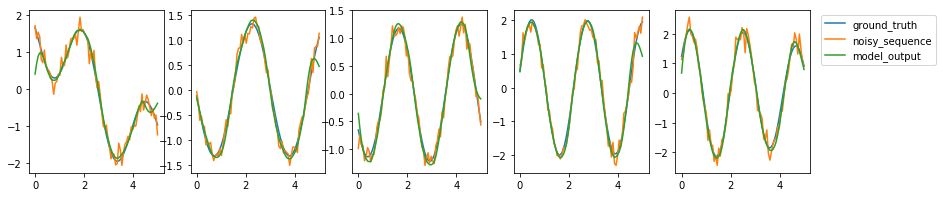

27.3677% of noise removed.


In [19]:
# don't forget to create a new model each time!
# START TODO #############
# Test a more deep network
def test(hs, sft, lr):
    model = NoiseRemovalModel(hidden_size=hs, shift=sft)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    print('Testing with params: [Hidden-Size: {}, Shift: {}, Learning-Rate: {}]'.format(
        hs, sft, lr))
    train(model, optimizer, scheduler, num_epochs, batch_size)

test(hs=30, sft=10, lr=0.001)
test(hs=50, sft=10, lr=0.01)
test(hs=80, sft=10, lr=0.01)

**Feedback**
1. Preliminary Questions: Took us about **1h**. Useful to recap think about RNN and LSTM.
2. LSTM Implementation: Took us about **8h**. It was not straight forward at all but using the diagram on the lecture slides we managed to grasp what we have to do. Problematic was to get used to the torch.tensor and available operations.
3. LSTM Use Case - Noise Removal: Took us about **4h**. The noise removal is quite a good example and this part was satisfying.